# Video 1 - Linear regression with swyft

In [2]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats

## Linear regression for a second order polynomial

$$y(x) = v_0 + v_1\cdot x + v_2 \cdot x^2$$

$$
d_i \sim  \mathcal{N}(y(x_i), \sigma = 0.05)\;, \quad \text{with}\quad x_i = 0,\; 0.1,\; 0.2, \;\dots,\; 1.0
$$

In [5]:
# Model and reference parameters
N = 11
x = np.linspace(0, 1, N)
T = np.array([x**0, x**1, x**2]).T
v_true = np.array([-0.2, 0., 0.2])

# Mock data
SIGMA = 0.05
np.random.seed(42)
DATA = T.dot(v_true) + np.random.randn(N)*SIGMA

v_0 = -0.188 +- 0.038 (-0.200)
v_1 = 0.098 +- 0.177 (0.000)
v_2 = 0.079 +- 0.171 (0.200)


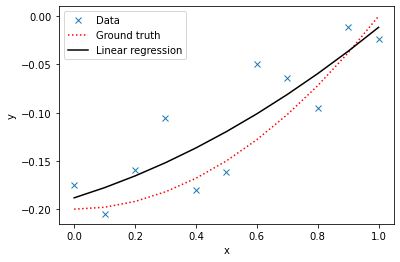

In [6]:
# Linear regression
v_lr = inv(T.T.dot(T)).dot(T.T.dot(DATA))
y_lr = T.dot(v_lr)

# Fisher estimation of errors
I = np.array([[(T[:,i]*T[:,j]).sum()/SIGMA**2 for i in range(3)] for j in range(3)])
Sigma = inv(I)
v_fisher_err = np.diag(Sigma)**0.5

# Plot
plt.plot(x, DATA, ls='', marker='x', label = 'Data')
plt.plot(x, T.dot(v_true), 'r:', label='Ground truth')
plt.plot(x, y_lr, 'k', label = 'Linear regression')
plt.legend()
plt.xlabel("x")
plt.ylabel('y');

for i in range(3):
    print("v_%i = %.3f +- %.3f (%.3f)"%(i, v_lr[i], v_fisher_err[i], v_true[i]))

## SWYFT!

In [7]:
import swyft

In [8]:
def model(v):
    y = T.dot(v)
    return dict(y=y)

sim = swyft.Simulator(model, ['v0', 'v1', 'v2'], dict(y=(11,)))

In [9]:
def noise(sim, v):
    d = sim['y'] + np.random.randn(11)*SIGMA
    return dict(d=d)

In [10]:
store = swyft.MemoryStore(sim)

Creating new store.


In [11]:
prior = swyft.Prior(lambda u: u*2 - 1, 3)   # Uniform(-1, 1)

In [12]:
store.add(20000, prior)

Store: Adding 19918 new samples to simulator store.


In [13]:
store.simulate()

In [22]:
dataset = swyft.Dataset(20000, prior, store, simhook = noise)

In [23]:
post = swyft.Posteriors(dataset)

In [24]:
%%time
marginals = [0, 1, 2]
post.add(marginals, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
post.train(marginals)

Training: lr=0.001, Epoch=15, VL=1.865
CPU times: user 37.2 s, sys: 5.05 s, total: 42.3 s
Wall time: 55.8 s


In [25]:
%%time
obs = dict(d=DATA)
samples = post.sample(1000000, obs)

CPU times: user 9.49 s, sys: 1.45 s, total: 10.9 s
Wall time: 10.9 s


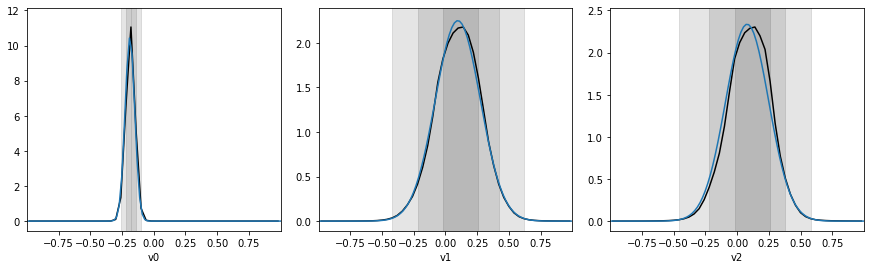

In [27]:
fig, diag = swyft.plot_1d(samples, [0, 1, 2], bins = 50, figsize=(15,4))
for i in range(3):
    x = np.linspace(-1, 1, 100)
    fig.axes[i].plot(x, stats.norm.pdf(x, v_lr[i], v_fisher_err[i]))

(<Figure size 720x720 with 9 Axes>,
 {(0,): {'mean': -0.18404610612339342,
   'mode': -0.170000071114163,
   'HDI1': (-0.21000003130551803, -0.170000071114163),
   'HDI2': (-0.24999999149687308, -0.130000110922808),
   'HDI3': (-0.26999997159255057, -0.09000015073145295),
   'entropy': -1.9304408820055046},
  (0, 1): None,
  (1,): {'mean': 0.10090094619783016,
   'mode': 0.13000043527244542,
   'HDI1': (-0.04999855655324492, 0.2699996511368713),
   'HDI2': (-0.24999743635956756, 0.4299987549819294),
   'HDI3': (-0.42999642818525796, 0.629997634788252),
   'entropy': -0.31483881177147294},
  (0, 2): None,
  (1, 2): None,
  (2,): {'mean': 0.09648108733775022,
   'mode': 0.1099988699083081,
   'HDI1': (-0.05000057349261239, 0.2499983828841137),
   'HDI2': (-0.22999994731864803, 0.40999782628503423),
   'HDI3': (-0.44999918199491384, 0.6099971305361849),
   'entropy': -0.3772931978964099}})

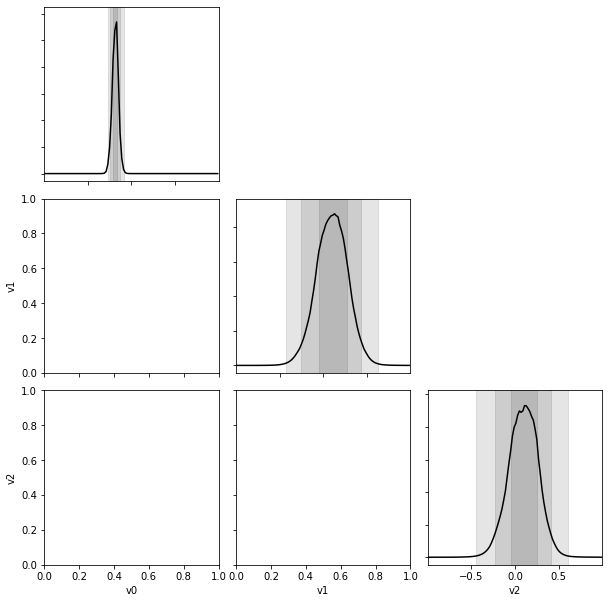

In [28]:
swyft.plot_corner(samples, [0, 1, 2])

In [29]:
%%time
marginals = [(0, 1), (0, 2)]
post.add(marginals, device =torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
post.train(marginals)

Training: lr=0.001, Epoch=17, VL=0.3455
CPU times: user 39.6 s, sys: 4.81 s, total: 44.4 s
Wall time: 1min 2s


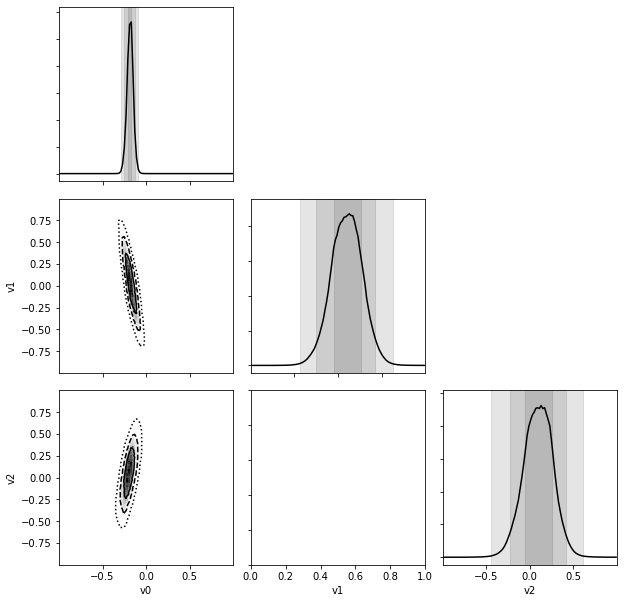

In [30]:
samples = post.sample(1000000, obs)
swyft.plot_corner(samples, [0, 1, 2]);